In [5]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load cleaned Netflix dataset
netflix_df = pd.read_csv('../data/clean/cleaned_netflix_data_with_platform.csv')

# Load cleaned Amazon dataset
amazon_df = pd.read_csv('../data/clean/cleaned_prime_data.csv')

#remove 'Unnamed' columns from Prime only
amazon_df = amazon_df.loc[:, ~amazon_df.columns.str.contains('^Unnamed')]

In [6]:
# Load the original CSV file
df = pd.read_csv('../data/clean/combined_cleaned_data.csv', sep=',', encoding='utf-8')

# Keep only the necessary columns
columns_to_keep = ['show_id', 'type', 'title', 'release_year', 
                   'rating', 'duration_int', 'duration_type', 
                   'genres', 'platform']

df_cleaned = df[columns_to_keep]

print("Cleaned file saved successfully.")


Cleaned file saved successfully.


In [7]:
# Generate new unique 'show_id' for each platform
netflix_df['show_id'] = ['n' + str(i + 1) for i in range(len(netflix_df))] 
amazon_df['show_id'] = ['p' + str(i + 1) for i in range(len(amazon_df))]

In [8]:
# Check columns to ensure alignment
print("Netflix columns:", netflix_df.columns)
print("Amazon columns:", amazon_df.columns)
# Confirm that IDs are correctly set
print(netflix_df[['show_id']].head())
print(amazon_df[['show_id']].head())

Netflix columns: Index(['show_id', 'type', 'title', 'release_year', 'rating', 'duration',
       'listed_in', 'duration_int', 'duration_type', 'genres', 'platform'],
      dtype='object')
Amazon columns: Index(['show_id', 'type', 'title', 'release_year', 'rating', 'duration',
       'duration_int', 'duration_type', 'genres', 'platform'],
      dtype='object')
  show_id
0      n1
1      n2
2      n3
3      n4
4      n5
  show_id
0      p1
1      p2
2      p3
3      p4
4      p5


In [9]:
# Check the columns of both DataFrames
print("Netflix columns:", netflix_df.columns)
print("Amazon columns:", amazon_df.columns)


Netflix columns: Index(['show_id', 'type', 'title', 'release_year', 'rating', 'duration',
       'listed_in', 'duration_int', 'duration_type', 'genres', 'platform'],
      dtype='object')
Amazon columns: Index(['show_id', 'type', 'title', 'release_year', 'rating', 'duration',
       'duration_int', 'duration_type', 'genres', 'platform'],
      dtype='object')


In [10]:
# Check if 'listed_in' column exists before dropping
if 'listed_in' in netflix_df.columns:
    netflix_df = netflix_df.drop(columns=['listed_in'])
    
if 'listed_in' in amazon_df.columns:
    amazon_df = amazon_df.drop(columns=['listed_in'])

# Verify the columns again
print("Netflix columns:", netflix_df.columns)
print("Amazon columns:", amazon_df.columns)

# Run the assertion check again
assert list(netflix_df.columns) == list(amazon_df.columns), "Column mismatch between Netflix and Amazon datasets"


Netflix columns: Index(['show_id', 'type', 'title', 'release_year', 'rating', 'duration',
       'duration_int', 'duration_type', 'genres', 'platform'],
      dtype='object')
Amazon columns: Index(['show_id', 'type', 'title', 'release_year', 'rating', 'duration',
       'duration_int', 'duration_type', 'genres', 'platform'],
      dtype='object')


In [11]:
assert list(netflix_df.columns) == list(amazon_df.columns), "Column mismatch between Netflix and Amazon datasets"


In [12]:
# Combine datasets
combined_df = pd.concat([netflix_df, amazon_df], ignore_index=True)

In [13]:
# Quick check
print(combined_df.shape)
print(combined_df['platform'].value_counts())

(18374, 10)
platform
Prime      9668
Netflix    8706
Name: count, dtype: int64


In [14]:
# Get unique genres
unique_genres = combined_df['genres'].unique()

# Create a DataFrame for the genres table
genres_df = pd.DataFrame({
    'genre_id': range(1, len(unique_genres) + 1),
    'genre': unique_genres
})

# Preview the genres table
print(genres_df)


    genre_id                 genre
0          1       ['Documentary']
1          2     ['International']
2          3   ['Action/Thriller']
3          4             ['Drama']
4          5              ['Kids']
5          6            ['Comedy']
6          7            ['Horror']
7          8         ['"Kids TV"']
8          9           ['Reality']
9         10    ['Sci-Fi/Fantasy']
10        11          ['TV Shows']
11        12            ['Movies']
12        13             ['Other']
13        14  ['Special Interest']


In [15]:
# Get unique movies
unique_movies = combined_df['title'].unique()

# Create a DataFrame for the movies table
movies_df = pd.DataFrame({
    'title_id': range(1, len(unique_movies) + 1),
    'movie_title': unique_movies
})

# Preview the movies table
print(movies_df)

       title_id              movie_title
0             1     Dick Johnson Is Dead
1             2            Blood & Water
2             3                Ganglands
3             4    Jailbirds New Orleans
4             5             Kota Factory
...         ...                      ...
17990     17991      Pride Of The Bowery
17991     17992            Planet Patrol
17992     17993                  Outpost
17993     17994  Maradona: Blessed Dream
17994     17995              Harry Brown

[17995 rows x 2 columns]


In [16]:
# Merge to get genre_id
movie_genres_df = combined_df[['show_id', 'genres']].merge(
    genres_df,
    left_on='genres',
    right_on='genre',
    how='left'
)[['show_id', 'genre_id']]

# Preview the movie_genres table
print(movie_genres_df.head())


  show_id  genre_id
0      n1         1
1      n2         2
2      n3         3
3      n4         1
4      n5         2


In [17]:
# Export genres table
genres_df.to_csv('../data/clean/genres_table.csv', index=False)

# Export movies table
movies_df.to_csv('../data/clean/movies_table.csv', index=False)

# Export movie_genres table
movie_genres_df.to_csv('../data/clean/movie_genres_table.csv', index=False)

print("Tables exported successfully!")


Tables exported successfully!


In [18]:
### Hypothesis 1
#"How Has the Average Movie Duration Changed Over the Years?"
# Filter only Movies
movies_df = combined_df[combined_df['type'] == 'Movie']

# Check the first few rows
print(movies_df[['title', 'release_year', 'duration_int', 'platform']].head())


                               title  release_year  duration_int platform
0               Dick Johnson Is Dead          2020            90  Netflix
6   My Little Pony: A New Generation          2021            91  Netflix
7                            Sankofa          1993           125  Netflix
9                       The Starling          2021           104  Netflix
12                      Je Suis Karl          2021           127  Netflix


In [19]:
# Group by release_year and platform, then calculate the average duration
avg_duration_movies = movies_df.groupby(['release_year', 'platform'])['duration_int'].mean().reset_index()

# Preview the result
print(avg_duration_movies.head())


   release_year platform  duration_int
0          1920    Prime        72.000
1          1922    Prime       133.000
2          1923    Prime       113.000
3          1924    Prime       118.000
4          1925    Prime        81.375


In [39]:
# Make sure the folder exists
os.makedirs('../data/plots/', exist_ok=True)

# Plot with specified colors
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')  # Optional, helps with grid visibility on dark background

# Plot the lineplot
sns.lineplot(
    data=avg_duration_movies,
    x='release_year',
    y='duration_int',
    hue='platform',
    palette={'Prime': '#1f77b4', 'Netflix': '#d62728'},  # Blue for Prime, Red for Netflix
    marker='o'
)

# Customize text and background colors
plt.title('How Movie Duration Has Changed Over Time: Netflix vs Prime Video', fontsize=14, fontweight='bold', color='white')
plt.xlabel('Release Year', fontsize=12, color='white')
plt.ylabel('Average Duration (minutes)', fontsize=12, color='white')

plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.legend(title='Platform', facecolor='black', edgecolor='white', labelcolor='white', title_fontsize=12, fontsize=10)
plt.gca().patch.set_facecolor('black')  # Set plot area background
plt.gcf().patch.set_facecolor('black')  # Set figure background

plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot with transparent background
plt.savefig(
    '../data/plots/average_movie_duration_by_platform.png',
    dpi=300,
    bbox_inches='tight',
    transparent=True  # Transparent outside the plot area, but inside remains black
)

# Show the plot
plt.show()




NameError: name 'os' is not defined

In [ ]:
## Group by 'release_year' and 'platform', then calculate the mean of the number of seasons for each group
avg_seasons_tv = combined_df[combined_df['type'] == 'TV Show'] \
    .groupby(['release_year', 'platform'])['duration_int'].mean().reset_index()

# Apply smoothing (rolling average)
avg_seasons_tv['smoothed'] = avg_seasons_tv.groupby('platform')['duration_int'] \
    .rolling(3, min_periods=1).mean().reset_index(drop=True)

# Create the plot with dark background and white text
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')  # Optional grid style

sns.lineplot(
    data=avg_seasons_tv,
    x='release_year',
    y='smoothed',
    hue='platform',
    palette={'Prime': '#1f77b4', 'Netflix': '#d62728'},  # Blue for Prime, Red for Netflix
    marker='o'
)

# Customize the plot aesthetics for dark background
plt.title('Are Seasons Getting Shorter? A Historical Comparison Between Netflix and Prime Video',
          fontsize=16, fontweight='bold', color='white')
plt.xlabel('Release Year', fontsize=14, color='white')
plt.ylabel('Average Number of Seasons', fontsize=14, color='white')

plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.legend(title='Platform', facecolor='black', edgecolor='white', labelcolor='white', title_fontsize=14, fontsize=12)
plt.gca().patch.set_facecolor('black')  # Plot area background
plt.gcf().patch.set_facecolor('black')  # Entire figure background

plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Export as PNG with transparent outside (but black background inside)
plt.savefig('../data/plots/average_seasons_tv_by_platform.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()




In [41]:
## Hypothesis 2
# (Ratings Analysis): “Amazon tends to push genre boundaries with more mature-rated content, while Netflix plays it safer with family-friendly options.”

In [ ]:
plt.style.use('dark_background')  # Keep black background

# Plotting the vertical bar plot
plt.figure(figsize=(8, 6))
bars = sns.barplot(
    x=mature_percentage.index, 
    y=mature_percentage.values, 
    palette={'Netflix': '#d62728', 'Prime': '#1f77b4'},  # Red for Netflix, Blue for Prime
    edgecolor='white'
)

# Add the percentage labels above each bar
for index, value in enumerate(mature_percentage.values):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center', fontsize=12, color='white', fontweight='bold')

# Title and labels
plt.title('How Much Mature Content Are You Watching? A Netflix vs Prime Showdown', fontsize=16, fontweight='bold')
plt.ylabel('Mature-rated Content (%)', fontsize=12)
plt.xlabel('Platform', fontsize=12)

# Layout adjustments
plt.ylim(0, 100)  # Set the scale to 0-100%
plt.tight_layout()

# Save the plot with transparent background and white text
plt.savefig('../data/plots/mature_content_comparison_vertical.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')  # Fondo negro

# Plot vertical con detalles visuales
plt.figure(figsize=(8, 6))
bars = sns.barplot(
    data=nature_percentage_movies,
    x='platform',
    y='mature_percentage',
    palette={'Netflix': '#d62728', 'Prime': '#1f77b4'},
    edgecolor='white'
)

# Etiquetas de porcentaje encima de cada barra
for index, row in nature_percentage_movies.iterrows():
    plt.text(index, row['mature_percentage'] + 1, f"{row['mature_percentage']:.1f}%", 
             color='white', ha='center', fontsize=12, fontweight='bold')

# Título llamativo y etiquetas
plt.title("How Mature Are Your Movie Nights? Netflix vs Prime", fontsize=16, fontweight='bold')
plt.ylabel('Mature-rated Movies (%)', fontsize=12)
plt.xlabel('Platform', fontsize=12)

# Ajustes visuales
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

# Guardar como PNG con fondo transparente
plt.savefig('../data/plots/mature_movies_comparison.png', dpi=300, bbox_inches='tight', transparent=True)

# Mostrar
plt.show()


C:\Users\PcVIP\AppData\Local\Temp\ipykernel_39324\2509275075.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


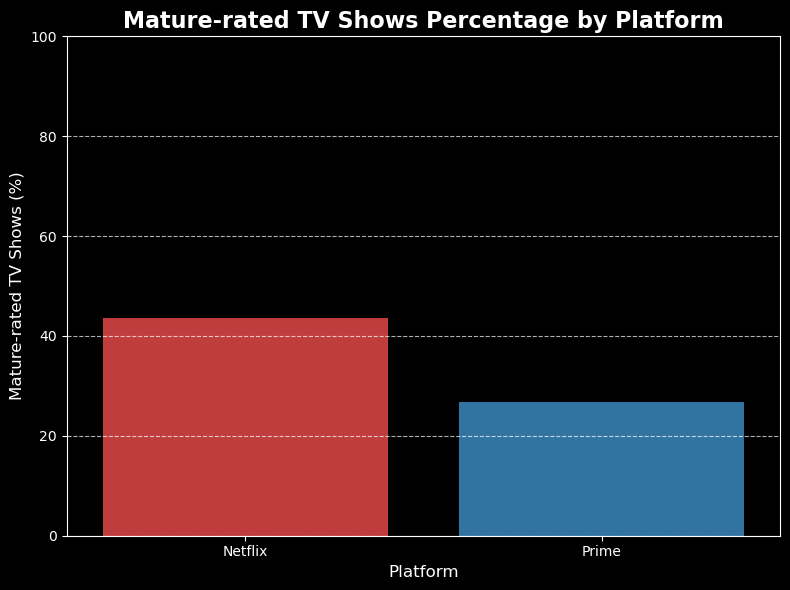

In [43]:
# Filter only TV Shows
tv_df = combined_df[combined_df['type'] == 'TV Show']

# Define the mature ratings for TV Shows
mature_ratings = ['R', 'TV-MA']

# Calculate the number of mature-rated TV shows for each platform
mature_counts_tv = tv_df[tv_df['rating'].isin(mature_ratings)].groupby('platform')['rating'].count()

# Calculate the total number of TV shows for each platform
total_counts_tv = tv_df['platform'].value_counts()

# Calculate the percentage of mature-rated TV shows for each platform
nature_percentage_tv = (mature_counts_tv / total_counts_tv) * 100

# Prepare the data as a DataFrame
nature_percentage_tv = nature_percentage_tv.reset_index()
nature_percentage_tv.columns = ['platform', 'mature_percentage']

# Create the bar plot with dark background style
plt.style.use('dark_background')
plt.figure(figsize=(8, 6))
sns.barplot(
    data=nature_percentage_tv, 
    x='platform', 
    y='mature_percentage', 
    palette={'Prime': '#1f77b4', 'Netflix': '#d62728'}
)

# Add labels and title
plt.title('Mature-rated TV Shows Percentage by Platform', fontsize=16, fontweight='bold', color='white')
plt.ylabel('Mature-rated TV Shows (%)', fontsize=12, color='white')
plt.xlabel('Platform', fontsize=12, color='white')
plt.ylim(0, 100)
plt.tick_params(colors='white')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and save the plot with transparent background
plt.tight_layout()
plt.savefig('../data/plots/mature_tvshows_percentage_by_platform.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()


In [ ]:
##How does the distribution of ratings compare between Netflix and Prime?

In [45]:
# Apply dark background style
plt.style.use('dark_background')

# Create the bar plot with improved visuals
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ratings_distribution,
    x='percentage',
    y='rating',
    hue='platform',
    palette={'Netflix': '#d62728', 'Prime': '#1f77b4'},
    edgecolor='white'
)

# Add percentage labels inside the bars
for index, row in ratings_distribution.iterrows():
    plt.text(
        row['percentage'] + 0.3,  # Horizontal position of the label
        index % 5 + 0.2,          # Vertical adjustment based on position
        f"{row['percentage']:.1f}%", 
        color='white', fontsize=10
    )

# Plot title and axis labels
plt.title('How Family-Friendly Are These Platforms? Rating Distribution on Netflix vs Prime', 
          fontsize=16, fontweight='bold', color='white')
plt.xlabel('Percentage of Titles (%)', fontsize=12, color='white')
plt.ylabel('Rating', fontsize=12, color='white')

# Adjust legend and ticks
plt.legend(title='Platform')
plt.tick_params(colors='white')
plt.grid(True, axis='x', linestyle='--', alpha=0.3)

# Adjust layout and save the plot with transparent background
plt.tight_layout()
plt.savefig('../data/plots/ratings_distribution_comparison.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()


NameError: name 'ratings_distribution' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
#export table
ratings_distribution.to_csv('../data/clean/ratings_distribution_comparison.csv', index=False)


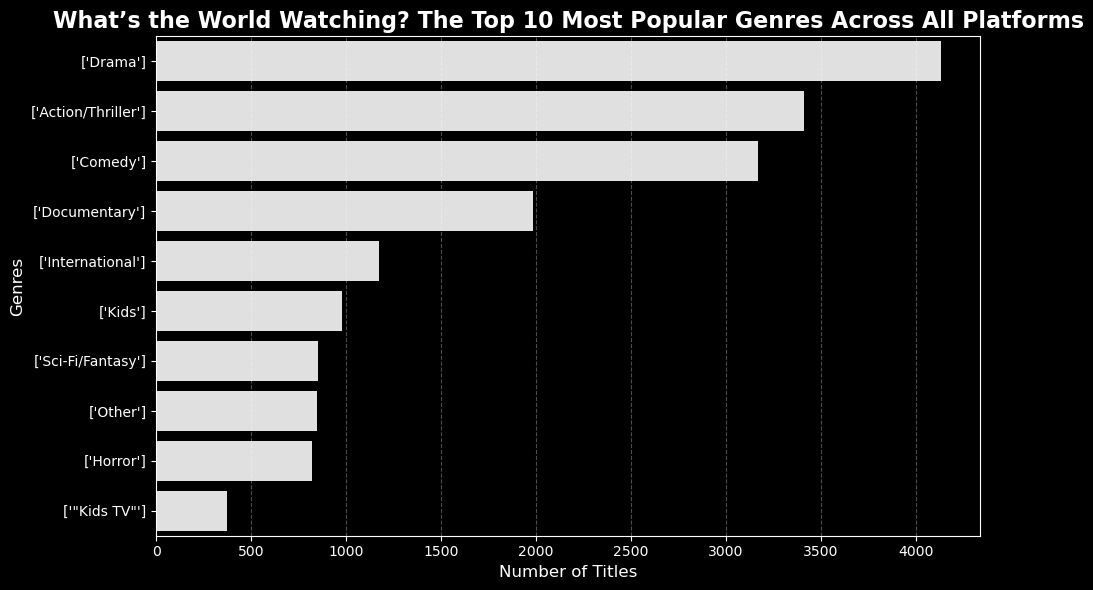

In [47]:
# Calculate the Top 10 Most Common Genres Globally (regardless of platform)
top_genres_global = combined_df.groupby('genres')['show_id'].count().sort_values(ascending=False).head(10)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_genres_global.values,
    y=top_genres_global.index,
    color='#e0e0e0'  # Soft white for bars
)

# Add plot title and labels
plt.title('What’s the World Watching? The Top 10 Most Popular Genres Across All Platforms', 
          fontsize=16, fontweight='bold', color='white')
plt.xlabel('Number of Titles', fontsize=12, color='white')
plt.ylabel('Genres', fontsize=12, color='white')

# Adjust tick colors and grid style
plt.gca().tick_params(colors='white')
plt.grid(True, axis='x', linestyle='--', alpha=0.3)

# Adjust layout and save the plot with transparent background
plt.tight_layout()
plt.savefig('../data/plots/top_genres_global.png', dpi=300, bbox_inches='tight', transparent=True)

# Display the plot
plt.show()


In [ ]:
##Content by type (Movies vs Tv Shows)

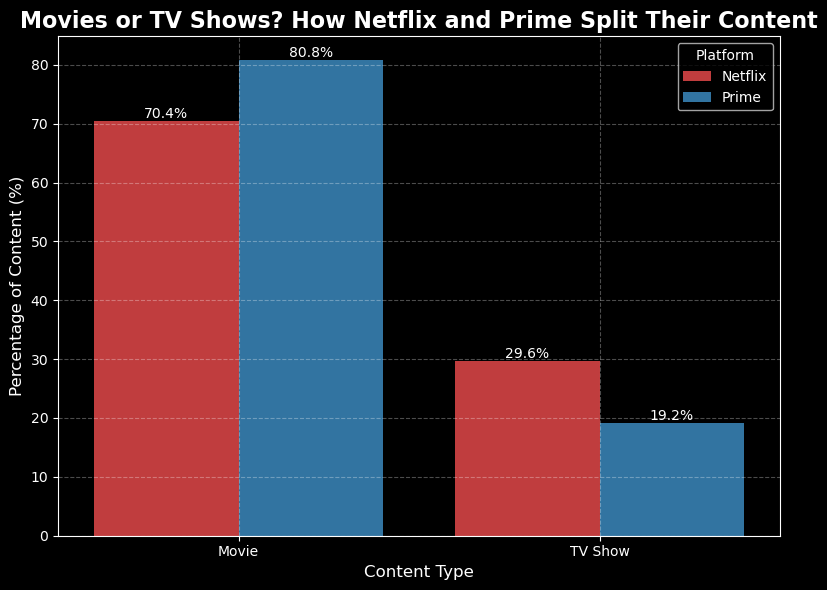

In [51]:
# Create the data
data = {
    'platform': ['Netflix', 'Netflix', 'Prime', 'Prime'],
    'type': ['Movie', 'TV Show', 'Movie', 'TV Show'],
    'percentage': [70.4, 29.6, 80.8, 19.2]
}
df = pd.DataFrame(data)

# Dark style for the plot
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 6))

# Consistent colors with the rest of the visuals
colors = {'Movie': '#d62728', 'TV Show': '#1f77b4'}

# Create the bar plot
sns.barplot(
    data=df,
    x='type',
    y='percentage',
    hue='platform',
    palette={'Netflix': '#d62728', 'Prime': '#1f77b4'},
    dodge=True,
    ax=ax
)

# Add percentage labels on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', color='white', fontsize=10)

# Plot aesthetics
ax.set_title('Movies or TV Shows? How Netflix and Prime Split Their Content', fontsize=16, fontweight='bold', color='white')
ax.set_ylabel('Percentage of Content (%)', fontsize=12, color='white')
ax.set_xlabel('Content Type', fontsize=12, color='white')
ax.legend(title='Platform', loc='upper right')
ax.tick_params(colors='white')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# Save the plot as PNG with transparent background
plt.savefig('../data/plots/netflix_prime_content_split.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()



In [ ]:
# Verifica si hay valores nulos
print(combined_df.isnull().sum())

# Verifica las primeras filas
print(combined_df.head())


In [ ]:
# Save the combined DataFrame as a CSV file
combined_df.to_csv('../data/clean/combined_final.csv', index=False)
print("Combined data saved as combined_final.csv successfully.")
